In [1]:
import os
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Raw data location

**In order to run this notebook, you need to first download the raw data from Dryad.**  
https://doi.org/10.5061/dryad.bnzs7h4c4

```DATA_DIR``` in the cell below must provide a path to the raw data folder.

In [2]:
DATA_DIR = '' # <--- Fill in after downloading the raw data.

#  
### Basic plotting utilities

In [3]:
def clean_axes_boxes(fig, keep_bottom_ticks=True):
    for ax in fig.get_axes():
        for sk, spine in ax.spines.items():
            spine.set_visible(sk in ['left', 'bottom'])
        ax.tick_params(top=False, bottom=keep_bottom_ticks)
        
def set_figure_tick_sizes(fig, x=None, y=None):
    for ax in fig.get_axes():
        if x is not None:
            for label in ax.get_xticklabels():
                label.set_fontsize(float(x))
        if y is not None:
            for label in ax.get_yticklabels():
                label.set_fontsize(float(y))
                
def set_figure_label_sizes(fig, x=None, y=None, t=None):
    for ax in fig.get_axes():
        if x is not None:
            ax.xaxis.label.set_fontsize(float(x))
        if y is not None:
            ax.yaxis.label.set_fontsize(float(y))
        if t is not None:
            ax.title.set_fontsize(float(t))

def clean_figure(fig=None):
    if fig is None:
        fig = plt.gcf()
    clean_axes_boxes(fig)
    set_figure_label_sizes(fig, x=14, y=14, t=14)
    set_figure_tick_sizes(fig, x=10, y=10)

# Load in data

In [4]:
def load_training_history(sweep_type, scenario):
    training_history_path = os.path.join(DATA_DIR, 'calibration', sweep_type, scenario, 'training_history.pkl')
    
    with open(training_history_path, 'rb') as f:
        training_history = pickle.load(f)
        
    return training_history

In [5]:
# Sweep over rates of a flat tax schedule, in Open Quadrant (4 agent)
quad_4_rate = load_training_history('fixed_tax_rate_sweep', 'open_quadrant_4')

In [6]:
# Sweep over elasticity parameters using the Saez formula, in Open Quadrant (4 agent)
quad_4_elas = load_training_history('saez_elasticity_sweep', 'open_quadrant_4')

In [7]:
# Sweep over elasticity parameters using the Saez formula, in Open Quadrant (10 agent)
quad_10_elas = load_training_history('saez_elasticity_sweep', 'open_quadrant_10')

In [8]:
# Sweep over elasticity parameters using the Saez formula, in Split World (0, 1, 2 on top)
split_012_elas = load_training_history('saez_elasticity_sweep', 'split_012')

In [9]:
# Sweep over elasticity parameters using the Saez formula, in Split World (2, 7 on top)
split_27_elas = load_training_history('saez_elasticity_sweep', 'split_27')

In [10]:
# Sweep over elasticity parameters using the Saez formula, in Split World (4, 5 on top)
split_45_elas = load_training_history('saez_elasticity_sweep', 'split_45')

In [11]:
# Sweep over elasticity parameters using the Saez formula, in Split World (7, 8, 9 on top)
split_789_elas = load_training_history('saez_elasticity_sweep', 'split_789')

# Empirical versus Optimal Elasticity (Open Quad w/ 4 agents)

The code below reproduces the paper figure which compares elasticity estimated via a sweep over flat tax rates versus the optimal elasticity (when using the Saez tax) identified by a sweep over elasticity parameters.

In [12]:
def extract_ols_data(rate_sweep_data, s0=None, sT=None, max_tax=1.0):
    X, Y = [], []
    for rate, run_datas in rate_sweep_data.items():
        rate = float(rate)
        if rate > max_tax:
            continue
            
        for run_data in run_datas:
            productivity = np.array(run_data['Productivity'])
            steps = np.array(run_data['Environment Steps'])
            
            keep = np.ones_like(productivity).astype(np.bool)
            if s0 is not None:
                keep = np.logical_and(keep, steps >= s0)
            if sT is not None:
                keep = np.logical_and(keep, steps <= sT)
                
            y = np.log(productivity[keep])
            x = np.log((1 - rate) * np.ones_like(y))
            
            X.append(x)
            Y.append(y)
            
    X = np.concatenate(X)
    Y = np.concatenate(Y)
    
    return X, Y

def grid_search_elasticity(elas_sweep_data, axes=None):
    if axes is None:
        _, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 6), sharex=True)
    else:
        ax0, ax1 = axes
        
    # Collect the social welfares for each run (averaged over last 100M steps), organized by elasticity
    iiwu_dict = {} # Inverse-Income Weighted Utility
    eqtp_dict = {} # Income Equality * Productivity
    elasticities = sorted([float(k) for k in elas_sweep_data.keys()])
    
    for e in elasticities:
        k = '{:3.1f}'.format(e)
        iiwu_dict[e] = [
            np.mean(run_data['Inverse-Income Weighted Utility'][run_data['Environment Steps'] >= 300e6])
            for run_data in elas_sweep_data[k]
        ]
        eqtp_dict[e] = [
            np.mean(run_data['Income Equality * Productivity'][run_data['Environment Steps'] >= 300e6])
            for run_data in elas_sweep_data[k]
        ]

    # Plot IIWU and Eq * P
    ax0.errorbar(
        elasticities,
        [np.mean(iiwu_dict[e]) for e in elasticities],
        yerr=[np.std(iiwu_dict[e])/np.sqrt(len(iiwu_dict[e])) for e in elasticities],
        marker='',
        linestyle='-',
        color='k'
    );
    ax1.errorbar(
        elasticities,
        [np.mean(eqtp_dict[e]) for e in elasticities],
        yerr=[np.std(eqtp_dict[e])/np.sqrt(len(eqtp_dict[e])) for e in elasticities],
        marker='',
        linestyle='-',
        color='k'
    );
    
    ax0.set_xlabel('Elasticity Used');
    ax1.set_xlabel('Elasticity Used');
    
    ax0.set_ylabel('Inverse-Income Weighted Utility');
    ax1.set_ylabel('Income Equality * Productivity');

def empirical_and_grid_search_elasticity(rate_sweep_data, elas_sweep_data, max_tax=1.0):
    """
    Compare elasticity estimated empirically from a sweep over flat rates and from a sweep over elasticity parameters.
    
    Args:
        rate_sweep_data: Pre-loaded training history from a sweep over rates using a flat tax schedule.
        elas_sweep_data: Pre-loaded training history from a sweep over elasticities using the Saez tax formula.
        max_tax: The maximum tax rate to consider in the OLS elasticity estimate. Defaults to 1.0 (all tax rates).
        
    Note:
        The two data sets should come from the same scenario (i.e., open quadrant, w/ 4 agents)
    """
    
    # Set up the plotting axes
    fig = plt.figure(figsize=(16, 6))
    
    gs = GridSpec(2, 2, width_ratios=[1.5, 1], wspace=0.2)
    
    ax0 = fig.add_subplot(gs[:, 0])
    ax1 = fig.add_subplot(gs[0, 1])
    ax2 = fig.add_subplot(gs[1, 1], sharex=ax1)
        
    # Extract the raw data for the elasticity OLS
    X, Y = extract_ols_data(rate_sweep_data, s0=75e6, sT=None, max_tax=max_tax)
    
    # Estimate elasticity via OLS
    X_ = np.stack([X, np.ones_like(X)]).T
    XXi = np.linalg.inv(X_.T.dot(X_))
    XY = X_.T.dot(Y)
    elas, log_z0 = XXi.T.dot(XY)

    # Plot the OLS data and the empirical elasticity obtained via regression
    SAMPLE = 10
    ax0.plot(X[::SAMPLE], Y[::SAMPLE], linestyle='', marker='.', color='k', alpha=0.5);
    ax0.set_xlabel('log net-of-tax-rate', fontsize=16)
    ax0.set_ylabel('log productivity', fontsize=16)

    xlim = ax0.get_xlim()
    xfit = [xlim[0], 0]
    yfit = [elas*x + log_z0 for x in xfit]
    ax0.plot(xfit, yfit, 'r--');
    ax0.set_xlim(xlim);

    # Plot IIWU and Eq * P
    grid_search_elasticity(elas_sweep_data, axes=[ax1, ax2])
    ax1.set_xlabel('');
    ax2.set_xlabel('Elasticity Used');
    ax1.set_ylabel('IIWU');
    ax2.set_ylabel('Eq. * Prod.');
    
    # Add a line to indicate the OLS estimate
    yL1 = ax1.get_ylim()
    yL2 = ax2.get_ylim()
    ax1.plot([elas, elas], yL1, 'r--');
    ax2.plot([elas, elas], yL2, 'r--');
    ax1.set_ylim(yL1);
    ax2.set_ylim(yL2);

    # Format
    ax0.set_xlim(right=0.05);
    ax0.set_ylim([6.5, 8.2]);
    
    ax1.set_ylim([60, 80]);
    ax2.set_ylim([280, 380]);
    
    ax0.set_title('Empirical Elasticity Estimate Using Flat Taxes');
    ax1.set_title('Grid-Search for Best Elasticity');

    return elas

## Paper Figure: Estimating elasticity for the Saez tax in the 4-agent Open-Quadrant scenario. 

0.8707917840226597


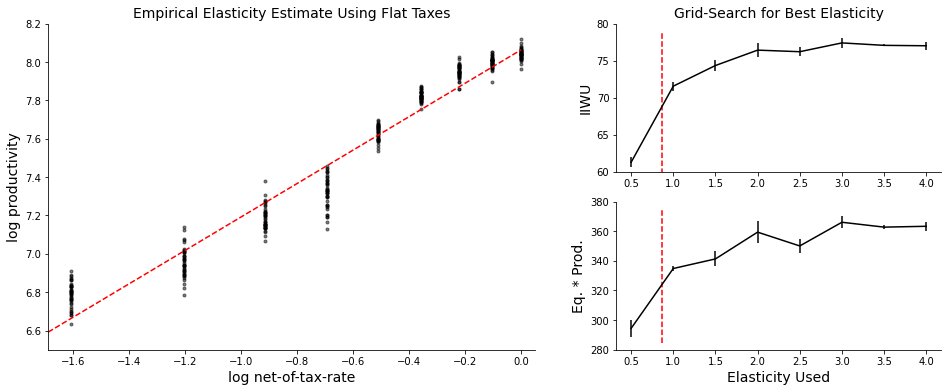

In [13]:
elas_quad = empirical_and_grid_search_elasticity(quad_4_rate, quad_4_elas)
print(elas_quad)

clean_figure(fig=plt.gcf())

### Estimating elasticity for the Saez tax in the 4-agent Open-Quadrant scenario. 

**Left**: Regression on income and marginal tax-rate data yields elasticity estimates eˆ of approximately 0.87 (slope of the red dotted line). The net-of-tax-rate is the fraction of income agents retain after paying taxes. Productivity is the total pre-tax income earned by the agents. Each dot represents a (productivity, tax rate) pair observed from a sweep over flat tax rates.

**Right**: Social welfare with agents trained to convergence under the Saez tax, using a grid-search
over elasticity parameters. Social welfare is highest under the Saez tax when the used elasticity
parameter is approximately 3, for both the inverse-income-weighted-utility objective
(top) and the equality-times-productivity objective (bottom). Error bars denote standard error
across the 3 random seeds used for each elasticity value.

#  
# Identifying Optimal Elasticity via Grid Search (for each scenario)

### Open Quadrant w/ 4 agents

### Open Quadrant w/ 4 agents

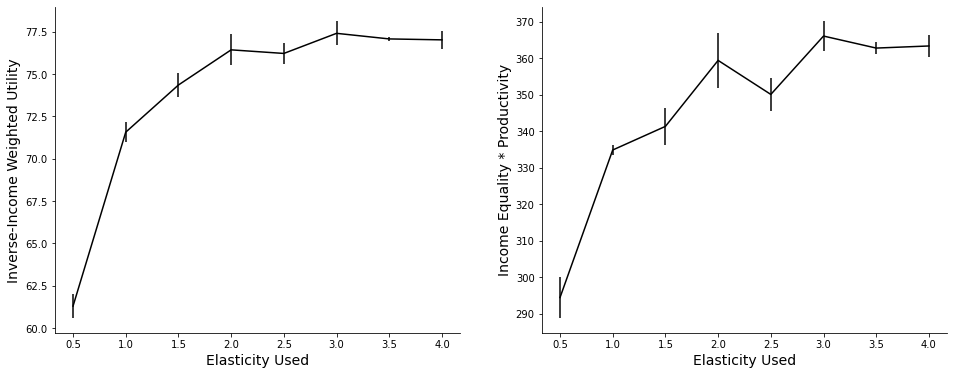

In [14]:
grid_search_elasticity(quad_4_elas)
clean_figure()

### Open Quadrant w/ 10 agents

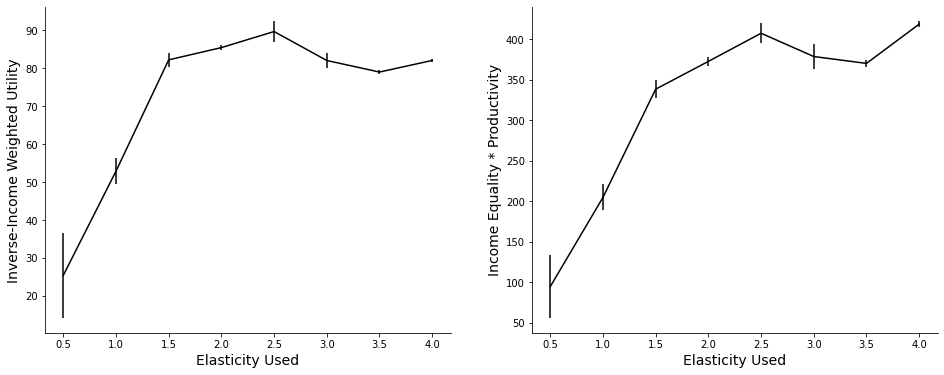

In [15]:
grid_search_elasticity(quad_10_elas)
clean_figure()

### Split World (10 agents) w/ skill ranks 0, 1, 2 in top half

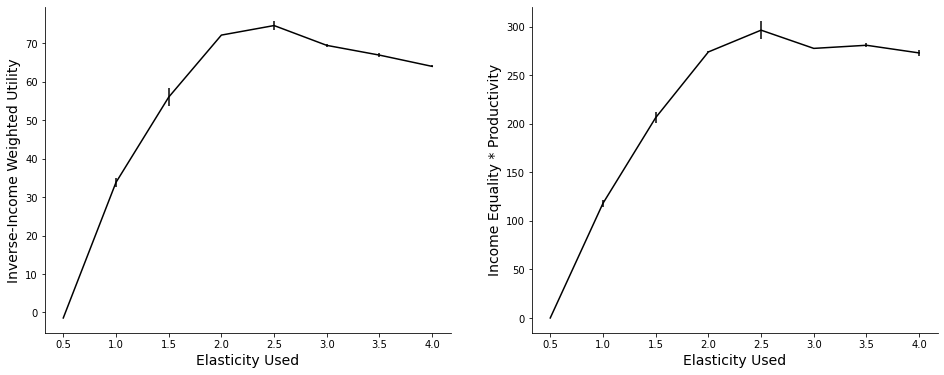

In [16]:
grid_search_elasticity(split_012_elas)
clean_figure()

### Split World (10 agents) w/ skill ranks 2, 7 in top half

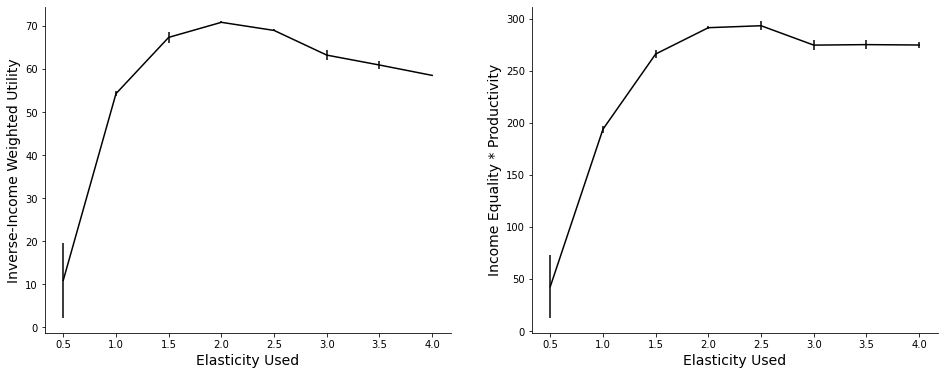

In [17]:
grid_search_elasticity(split_27_elas)
clean_figure()

### Split World (10 agents) w/ skill ranks 4, 5 in top half

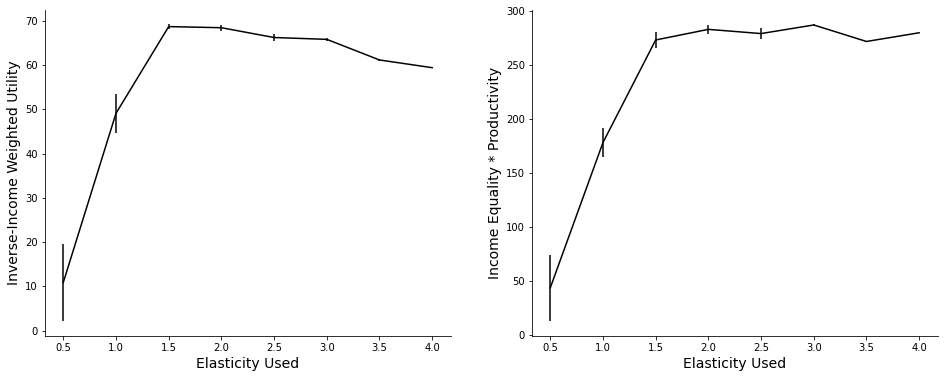

In [18]:
grid_search_elasticity(split_45_elas)
clean_figure()

### Split World (10 agents) w/ skill ranks 7, 8, 9 in top half

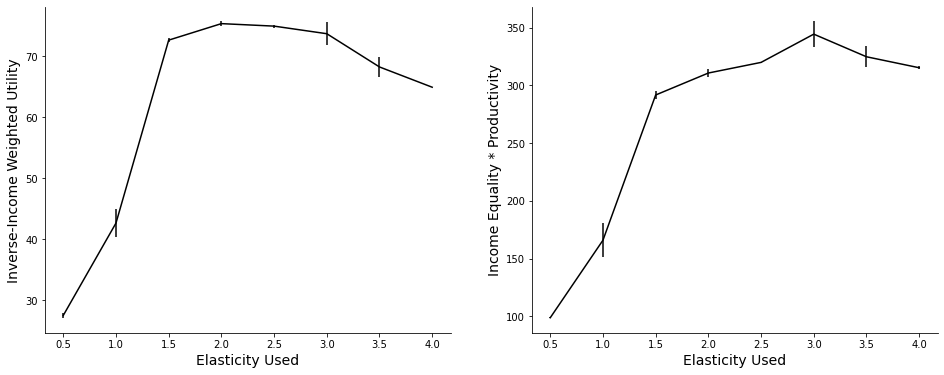

In [19]:
grid_search_elasticity(split_789_elas)
clean_figure()